# Surrogate Model for Capital Optimisation

This notebook demonstrates how to train a surrogate model to approximate Solvency Capital Requirements (SCR) under different reinsurance configurations using Gaussian Processes.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from mpl_toolkits.mplot3d import Axes3D

## Step 1: Generate Synthetic Capital Model Outputs

In [2]:
np.random.seed(42)
retention = np.linspace(100_000, 500_000, 10)
quota_share = np.linspace(0.1, 0.9, 10)
R, Q = np.meshgrid(retention, quota_share)
X = np.vstack([R.ravel(), Q.ravel()]).T

def true_icm_model(x):
    r, q = x[:, 0], x[:, 1]
    base_scr = 1e8
    impact = (1 - q)**1.5 * (r / 100_000)**0.3
    noise = np.random.normal(0, 0.01 * base_scr, size=len(x))
    return base_scr + 0.5 * impact * 1e6 + noise

y = true_icm_model(X)

## Step 2: Train Gaussian Process Surrogate Model

In [3]:
kernel = C(1.0, (1e-2, 1e2)) * RBF([1e5, 0.1], (1e4, 1e6))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, normalize_y=True)
gp.fit(X, y)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:660: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL: .

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 1 of parameter k2__length_scale is close to the specified lower bound 10000.0. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=[1e+05, 0.1]),
                         n_restarts_optimizer=10, normalize_y=True)

## Step 3: Predict SCR over a Dense Grid

In [4]:
retention_pred = np.linspace(100_000, 500_000, 50)
quota_share_pred = np.linspace(0.1, 0.9, 50)
R_pred, Q_pred = np.meshgrid(retention_pred, quota_share_pred)
X_pred = np.vstack([R_pred.ravel(), Q_pred.ravel()]).T
y_pred, y_std = gp.predict(X_pred, return_std=True)

## Step 4: Visualise Predicted SCR

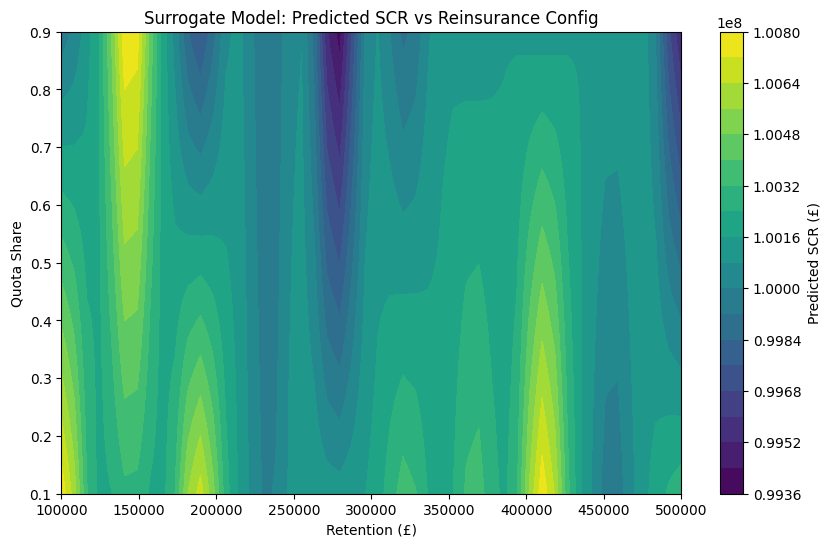

In [5]:
fig = plt.figure(figsize=(10, 6))
cs = plt.contourf(R_pred, Q_pred, y_pred.reshape(R_pred.shape), levels=20, cmap='viridis')
plt.colorbar(cs, label='Predicted SCR (£)')
plt.xlabel("Retention (£)")
plt.ylabel("Quota Share")
plt.title("Surrogate Model: Predicted SCR vs Reinsurance Config")
plt.show()